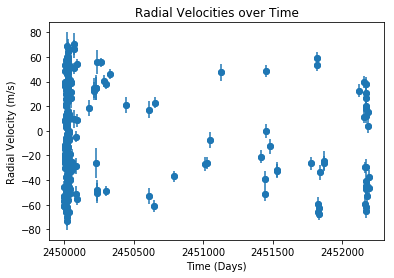

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#To plot the velocity vs time:
Data = np.loadtxt('C:/Users/M.C.S/Desktop/Data.txt') #Load Data from text file
Day = Data[0:,0] #Dates
V = Data[0:,1] #Velocities
errV = Data [0:,2] #uncertainty in V
plt.scatter(Day, V)
plt.errorbar(Day, V, yerr=errV, fmt='o')
plt.xlabel('Time (Days)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocities over Time')
plt.show()

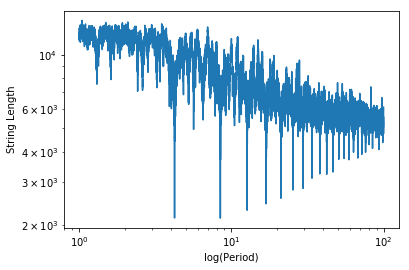

In [2]:
#To calculate the phase:
period = np.logspace(0,2,1e4) #periods between 1 and 100 days
string_length = []
for i in period:
    phi= (Day%i)/i 
    #To sort phase and velocity:
    V_sorted = V[np.argsort(phi)] 
    phi_sorted = sorted(phi)
    L_phi0, L_phi1 = phi_sorted[:-1], phi_sorted[1:]
    L_V0, L_V1 = V_sorted[:-1], V_sorted[1:] 
    #To make L_phi0, L_phi1, L_V0, L_V1 into numpy arrays, since they are lists:
    phi0, phi1 = np.asarray(L_phi0), np.asarray(L_phi1)
    V0, V1 = np.asarray(L_V0), np.asarray(L_V1)
    string= np.sum(np.sqrt((phi1-phi0)**2 + (V1-V0)**2))
    string_length.append(string)
string_length = np.asarray(string_length)
#To plot string length vs peroid:
plt.loglog(period, string_length)
plt.xlabel(r'log(Period)')
plt.ylabel(r'String Length')
plt.show()

The first minimum is at 4.23119115611 Days


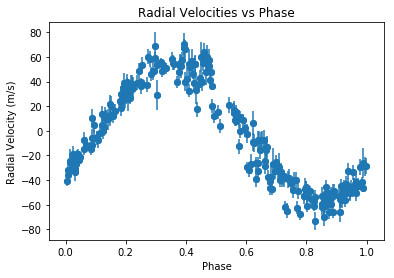

In [3]:
#The first minima is seen to be somewhere under 5 days, so we use a mask:
mask = period < 5
Length = string_length[mask]
Min = period[np.argmin(Length)]
print('The first minimum is at', Min, 'Days')
#so for one phase:
phase = (Day%Min)/Min 
phi_f = sorted(phase)
V_f = V[np.argsort(phase)]
errV_f = errV[np.argsort(phase)]
plt.scatter(phi_f, V_f)
plt.errorbar(phi_f, V_f, yerr=errV_f, fmt='o')
plt.xlabel(r'Phase')
plt.ylabel(r'Radial Velocity (m/s)')
plt.title('Radial Velocities vs Phase')
plt.show()

Value for parameter a = 55.6851283975 m/s, and its error err_a = 0.27013349675 m/s
Value for parameter b = -47.7437108843 rad, and its error err_b = 8.64166250049e-05 rad


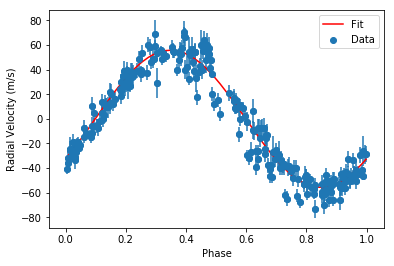

In [4]:
import scipy.optimize as so
phi_f = np.asarray(phi_f)
#To be able to fit the previous plot, we use this function:
def f(x,a,b):                        
    f = a*np.sin(2*np.pi*x + b)
    return f
#To get the parameters and their error:
popt, pcov = so.curve_fit(f, phi_f, V_f, sigma = errV_f, absolute_sigma=True)
a, err_a = abs(popt[0]), pcov[0][0]  
b, err_b = popt[1], pcov[1][1]
print('Value for parameter a =',a,'m/s, and its error err_a =', err_a, 'm/s')
print('Value for parameter b =',b,'rad, and its error err_b =', err_b, 'rad')
plt.scatter(phi_f, V_f, label= 'Data')
plt.errorbar(phi_f, V_f, yerr=errV_f, fmt='o')
plt.plot(phi_f, f(phi_f, -1*a, b), c='r', label='Fit') #negative is added here since a was originally negative.
plt.xlabel(r'Phase')
plt.ylabel(r'Radial Velocity (m/s)')
plt.legend()
plt.show()

In [5]:
#Calculations:
G = 6.67e-11
m_star = 1.989e30 #mass of star
m_jup = 1.898e27 #mass of jupiter 
T = Min #The period
K_obs_star = a #amplitude of velocity
sin_i = 1 #inclination
q = ((T*24*60*60/(2*np.pi*G*m_star))**(1/3))*(K_obs_star/sin_i)
print("Ratio of object's mass and star mass q =", q)
print("Object mass is =", q*m_star/m_jup, 'mass of Jupiter')
print("The object can be considered a planet since its mass is almost half that of Jupiter")

Ratio of object's mass and star mass q = 0.000423075483884
Object mass is = 0.443359924892 mass of Jupiter
The object can be considered a planet since its mass is almost half that of Jupiter


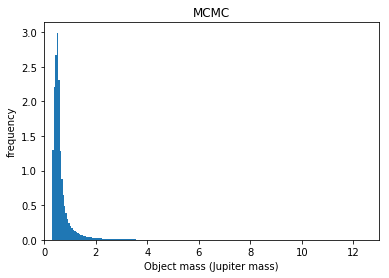

The probability of object being less than 13 times mass of Jupiter is p = 0.999406
But notice that the probability distribution is not symmetric
The median of this distribution is = 0.535056018413
Probability at 1 sigma 0.341344746068543
Probability at 2 sigma 0.477249868051821
Probability at 3 sigma 0.49865010196837
Probability at 4 sigma 0.499968328758167
Probability at 5 sigma 0.499999713348428


In [10]:
#Using Monte-Carlo error propagation:
n = 1000000
MC_K_obs_star = np.random.normal(loc=K_obs_star, scale=err_a**2, size=n)
MC_m_star = np.random.uniform(0.6*m_star, 1.4*m_star, n)
#To calculate the sin from cos:
MC_cosi = np.random.uniform(0, 1, 1000000)
MC_sini = np.sqrt(1 - MC_cosi**2)
q = ((T*24*60*60/(2*np.pi*G*MC_m_star))**(1/3))*(MC_K_obs_star/MC_sini)*(MC_m_star/m_jup)
#Plotting:
plt.hist(q, bins=10000, normed = True, label = 'MC')
plt.xlabel('Object mass (Jupiter mass)')
plt.ylabel('frequency')
plt.title('MCMC')
plt.xlim(0,13)
plt.show()
#Probability that planet has a size less than 13 times M_jup is:
#number of times planet's mass <13 M_jup divided by total masses we have
prob = np.size(q[q<13])/np.size(q) 
print('The probability of object being less than 13 times mass of Jupiter is p =' , prob)
print("But notice that the probability distribution is not symmetric")
med = np.median(q)
print('The median of this distribution is =', med)
#Sigma Confidence:
population = [0.682689492137086, 0.954499736103642, 0.997300203936740, 0.999936657516334, 0.999999426696856]
for i in range(5):
    mask1 = q >= med
    mask2 = q <= med
    p1 = (population[i]/2)*np.size(q[mask1]) 
    p2 = (population[i]/2)*np.size(q[mask2]) 
    p = (p1+p2)/np.size(q) #probabilty at sigma level i+1
    print("Probability at", i+1, 'sigma is', p)